# [DACON] 생육 환경 최적화 경진대회
[참고 | CNN+CatBoost+ANN](https://dacon.io/competitions/official/235897/codeshare/5017?page=1&dtype=recent)  
- DL과 ML을 섞어 사용했다는 점이 흥미로웠음

### Abstraction
- CNN: 이미지 밝기 조절 -> 마스킹(HSV) -> 픽셀 비율 추출 -> 이상치 처리 -> 학습
- CatBoost, ANN : 이미지 픽셀 비율 Feature 변수로 포함 -> 전처리 -> 학습

### Library

In [31]:
import os
from glob import glob

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import groupby
import random

import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import koreanize_matplotlib

In [23]:
main_path = "./open"
train_imgs = glob(main_path + "/train/*/*/*.png") + glob(main_path + "/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path + "/test/image/*.png") + glob(main_path + "/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path + "/train/*/meta/*.csv")
train_data = sorted(train_data)
train_label = glob(main_path + "/train/*/*.csv")
train_label = sorted(train_label)
test_data = glob(main_path + "/test/meta/*.csv")
test_data = sorted(test_data)

preprocessing_train_imgs = main_path + "/PREPROCESSING-TRAIN"
preprocessing_test_imgs = main_path + "/PREPROCESSING-TEST"

if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)

### Image Augmentation
Grayscale 히스토그램을 이용해 모든 이미지 밝기 자동 조절

In [24]:
def automatic_brightness_and_contrast(img, clip_hist_pct=0.025):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate grayscale hist
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_size = len(hist)
    # Calculate cumulative distribution from the hist
    accumulator = []
    accumulator.append(float(hist[0]))
    for idx in range(1, hist_size):
        accumulator.append(accumulator[idx-1]+float(hist[idx]))
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_pct *= (maximum/100.0)
    clip_hist_pct /= 2.0
    # Locate Left Cut
    minimum_gray = 0
    while accumulator[minimum_gray]<clip_hist_pct: minimum_gray += 1
    # Locate Right Cut
    maximum_gray = hist_size-1
    while accumulator[maximum_gray]>=(maximum-clip_hist_pct): maximum_gray -= 1
    # Calculate alpha and beta val.
    alpha = 255 / (maximum_gray-minimum_gray)
    beta = -minimum_gray*alpha

    auto_result = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return (auto_result)

### Data Processing
- 이미지 밝기 조절 후 HSV를 이용해 특정 색상 오브젝트 추출
- 마스킹 된 이미지 픽셀 비율 값 추출 (W / W + B)

In [25]:
def get_image_data(dir_in, dir_out):
    ratio_list = []
    for i in tqdm(dir_in):
        name = i.split("\\")[-1]
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (615, 462))
        brightscale = automatic_brightness_and_contrast(img)
        imgcopy = brightscale.copy()
        hsvimg = cv2.cvtColor(brightscale, cv2.COLOR_BGR2HSV)
        lower = np.array([22, 40, 0])
        upper = np.array([85, 255, 245])
        mask = cv2.inRange(hsvimg, lower, upper)
        number_of_white_pix = np.sum(mask==255)
        number_of_black_pix = np.sum(mask==0)
        ratio = number_of_white_pix / (number_of_white_pix + number_of_black_pix)
        ratio_list.append(ratio)
        result = cv2.bitwise_and(imgcopy, imgcopy, mask=mask)
        cv2.imwrite(os.path.join(dir_out, name), result)
    return ratio_list

In [26]:
ratio_train = get_image_data(train_imgs, preprocessing_train_imgs)
ratio_test = get_image_data(test_imgs, preprocessing_test_imgs)

processed_train_imgs = glob(main_path+"/PREPROCESSING-TRAIN/*.png") + glob(main_path+"/PREPROCESSING-TRAIN/*.jpg")
processed_train_imgs = sorted(processed_train_imgs)

processed_test_imgs = glob(main_path+"/PREPROCESSING-TEST/*.png") + glob(main_path+"/PREPROCESSING-TEST/*.jpg")
processed_test_imgs = sorted(processed_test_imgs)

100%|██████████| 460/460 [01:02<00:00,  7.41it/s]


- 정량이 정해져 있는 변수는 `bfill, ffill`로 결측값 대체 (최근 분무량)
- 정량이 정해져 있지 않은 변수는 보간법 이용
- 최근 분무량 데이터는, 일간 누적 분무량으로 측정이 되어 모든 최근 분무량 데이터를 일간 누적 분무량으로 변환
- 메타데이터에 픽셀 비율 변수로 포함

In [27]:
train_df = []
for i in tqdm(train_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    case = name.split("_")[0]
    label = pd.read_csv(main_path + f"/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _ in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df['비율'] = ratio_train
train_df.head()

100%|██████████| 1592/1592 [00:20<00:00, 76.57it/s] 


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,...,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지,비율
0,22.236181,43.868542,77.740695,4.679291,487.226389,19.594792,0.0,200.720833,201.000000,0.139583,...,179.460356,18.854103,10.228598,145.944829,12.396061,21.119466,NaN,49.193,CASE01_01,0.099845
1,23.011319,44.573750,77.645972,4.537500,480.144444,20.855555,0.0,200.861111,200.861111,0.139583,...,179.471631,18.853965,13.709128,145.980283,12.391464,21.099885,NaN,59.764,CASE01_02,0.120072
2,22.931111,39.537708,77.514931,4.886111,489.068750,20.748611,0.0,200.651042,200.373264,0.139583,...,179.523570,18.854171,13.348331,146.015736,12.374227,21.133608,NaN,72.209,CASE01_03,0.141682
3,21.027986,58.497500,80.069930,3.908333,481.378472,18.195278,0.0,200.025000,200.163889,0.139583,...,179.495845,18.854174,7.520480,145.997472,12.370205,21.128169,NaN,85.737,CASE01_04,0.166269
4,21.874305,67.058819,81.349792,3.908333,490.568750,19.400486,0.0,200.861111,201.000000,0.139583,...,179.488241,18.854140,10.943552,145.971688,12.394912,21.121642,NaN,102.537,CASE01_05,0.191539


In [28]:
test_df = []
for i in tqdm(test_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop("시간", axis=1)
    df["최근분무량"] = df["최근분무량"].fillna(method="bfill", limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method="ffill", limit=1)
    df = df.interpolate()
    water = df["최근분무량"].round(2).tolist()
    if np.mean(water)>1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x!=0) if k != 0]
        if len(nums)==2: cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else: cumulative = nums[0][-1] - nums[0][0]
    elif 1000>np.mean(water)>0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0
    
    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df["최근분무량"] = cumulative

    test_df.append(df)

test_df = pd.concat(test_df, ignore_index=True)
test_df["비율"] = ratio_test
test_df.head()

100%|██████████| 460/460 [00:10<00:00, 42.05it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,이미지,비율
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,11509.28,47.195486,7.484722,13.488194,22.395829,6.198268,20.395829,0.000000,179.576697,146.045817,12.398359,21.132520,001,0.162271
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,4234.63,33.496181,9.506597,4.722222,23.396007,23.875345,22.396007,0.000000,126.724400,103.602930,15.725197,7.396273,002,0.526755
2,25.999340,25.541111,79.197812,65.936597,498.623611,1.778872,610.71,47.185417,7.487153,13.476736,20.291920,42.908664,17.416844,0.606961,179.532997,146.026479,12.390315,21.116202,003,0.011583
3,22.956944,22.361667,70.809792,45.378646,394.612500,0.592409,12271.85,47.183333,7.483333,13.479514,22.395793,2.911434,20.395793,0.000000,179.449739,145.950201,12.392039,21.107500,004,0.149083
4,23.014757,22.531736,73.886944,33.534167,418.561806,0.541303,13040.85,47.185417,7.466667,13.478125,22.395846,3.179260,20.395846,0.000000,179.480870,145.998546,12.365033,21.117290,005,0.168687


### Image EDA
- 산점도 플롯을 이용해 무게, 픽셀 비율 관계 확인
- 회귀선에서 멀리 떨어져 있는 값은 이상치로 처리 (제거)
- CASE59와 CASE58은 중복 데이터임

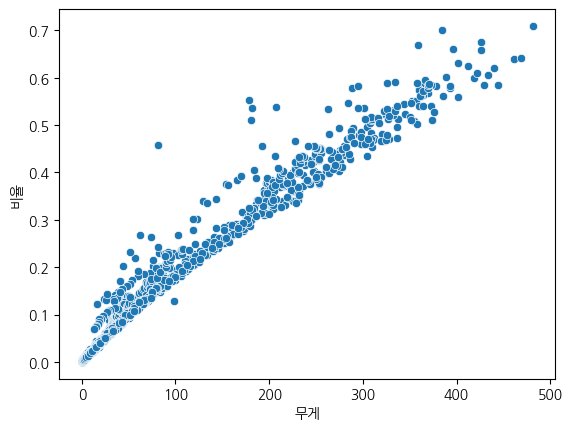

In [32]:
_ = sns.scatterplot(data=train_df, x="무게", y="비율")

In [33]:
image_outliers = ['CASE05_21','CASE05_22','CASE05_23', 'CASE07_07', 'CASE07_08', 'CASE16_03', 'CASE23_01', 'CASE23_02', 
'CASE23_03', 'CASE23_04', 'CASE23_05', 'CASE23_06', 'CASE23_07', 'CASE23_08', 'CASE23_09', 'CASE45_16', 'CASE45_17',
'CASE72_06',  'CASE73_10', 'CASE59_01','CASE59_02','CASE59_03','CASE59_04','CASE59_05','CASE59_06',
'CASE59_07','CASE59_08','CASE59_09','CASE59_10','CASE59_11','CASE59_12','CASE59_13','CASE59_14','CASE59_15','CASE59_16','CASE59_17','CASE59_18',
'CASE59_19','CASE59_20','CASE59_21','CASE59_22','CASE59_23','CASE59_24','CASE59_25','CASE59_26','CASE59_27','CASE59_28','CASE59_29','CASE59_30',
'CASE59_31','CASE59_32', 'CASE59_33']

train_df_image = train_df[~train_df["이미지"].isin(image_outliers)]
train_imgs_removed = [x for x in processed_train_imgs if x.split(".")[1].split("\\")[1] not in image_outliers]

### CNN

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
    print("GPU")
else:
    print("CPU")

CPU


이전에는 토치 GPU 구동 확인을 했었는데 왜 CPU로 잡히는지 모르겠음...

In [37]:
CFG = {
    "IMG_SIZE" : 128,
    "EPOCHS" : 80,
    "LEARNIING_RATE" : 1e-3,
    "BATHCH_SIZE" : 32,
    "SEED" : 42
}